In [1]:
import fsspec
import cf_xarray #noqa
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from kerchunk.netCDF3 import NetCDF3ToZarr


fs_read = fsspec.filesystem('s3', anon=True, skip_instance_cache=True, use_ssl=False) # For now SSL false is solving my cert issues **shrug**
fs_write = fsspec.filesystem('')

In [2]:
ngofs_files = fs_read.glob('s3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f*.20240228.t09z.nc')

ngofs_files = sorted(['s3://'+f for f in ngofs_files])
ngofs_files

['s3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f000.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f003.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f006.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f009.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f012.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f015.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f018.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f021.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f024.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f027.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f030.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f033.20240228.t09z.nc',
 's3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f036.20240

In [13]:
def add_fvcom_mesh(refs: dict) -> dict:
    refs['refs']['fvcom_mesh/.zattrs'] = "{\"_ARRAY_DIMENSIONS\":[],\"cf_role\":\"mesh_topology\", \"topology_dimension\":2, \"node_coordinates\":\"lon lat\", \"face_coordinates\":\"lonc latc\", \"face_node_connectivity\":\"nv\", \"face_face_connectivity\":\"nbe\"}"
    refs['refs']['fvcom_mesh/.zarray'] = "{\"chunks\":[],\"compressor\":null,\"dtype\":\"<i4\",\"fill_value\":null,\"filters\":null,\"order\":\"C\",\"shape\":[],\"zarr_format\":2}"
    refs["refs"]["fvcom_mesh/0"] = "\u0000\u0000\u0000\u0000"
    return refs

In [16]:
import ujson

def generate_json(f):
    outname = f'./ngofs2/{f.split("/")[-1]}.json'

    chunks = NetCDF3ToZarr(f, storage_options={'anon': True})
    refs = chunks.translate()
    refs = add_fvcom_mesh(refs)
    with fs_write.open(outname, 'w') as ofile:
        ofile.write(ujson.dumps(refs))

    return outname

In [17]:
print(f'Generating Zarr metadata for {ngofs_files[1]}')
print(f'Wrote Zarr metadata to {generate_json(ngofs_files[1])}')

Generating Zarr metadata for s3://noaa-ofs-pds/ngofs2.20240228/nos.ngofs2.fields.f003.20240228.t09z.nc
Wrote Zarr metadata to ./ngofs2/nos.ngofs2.fields.f003.20240228.t09z.nc.json


In [18]:
# open dataset as zarr object using fsspec reference file system and xarray
fs = fsspec.filesystem("reference", fo='./ngofs2/nos.ngofs2.fields.f003.20240228.t09z.nc.json', remote_protocol='s3', remote_options={'anon':True})
m = fs.get_mapper("")

ds = xr.open_dataset(m, engine="zarr", chunks={}, drop_variables=['Itime2'], backend_kwargs=dict(consolidated=False))
ds

<xarray.Dataset>
Dimensions:             (time: 1, four: 4, nele: 569405, node: 303714,
                         three: 3, maxnode: 10, maxelem: 8, siglev: 41,
                         siglay: 40)
Coordinates:
    lat                 (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    latc                (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    lon                 (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    lonc                (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    siglay              (siglay, node) float32 dask.array<chunksize=(40, 303714), meta=np.ndarray>
    siglev              (siglev, node) float32 dask.array<chunksize=(41, 303714), meta=np.ndarray>
  * time                (time) datetime64[ns] 2024-02-28T12:00:00
Dimensions without coordinates: four, nele, node, three, maxnode, maxelem
Data variables: (12/42)
    Itime               (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    Times               (time) |S26 dask.array<chunksize=(1,), meta=np.ndarray>
    a1u                 (four, nele) float32 dask.array<chunksize=(4, 569405), meta=np.ndarray>
    a2u                 (four, nele) float32 dask.array<chunksize=(4, 569405), meta=np.ndarray>
    art1                (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    art2                (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    ...                  ...
    ww                  (time, siglay, nele) float32 dask.array<chunksize=(1, 40, 569405), meta=np.ndarray>
    x                   (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    xc                  (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    y                   (node) float32 dask.array<chunksize=(303714,), meta=np.ndarray>
    yc                  (nele) float32 dask.array<chunksize=(569405,), meta=np.ndarray>
    zeta                (time, node) float32 dask.array<chunksize=(1, 303714), meta=np.ndarray>
Attributes: (12/14)
    Conventions:                 CF-1.0
    CoordinateProjection:        init=nad83:4205
    CoordinateSystem:            GeoReferenced
    GroundWater_Forcing:         GROUND WATER FORCING IS OFF!
    River_Forcing:               THERE ARE 63 RIVERS IN THIS MODEL.\nRIVER IN...
    Surface_Heat_Forcing:        FVCOM variable surface heat forcing file:\nF...
    ...                          ...
    Tidal_Forcing:               TIDAL ELEVATION FORCING IS OFF!
    history:                     model started at: 28/02/2024   09:14
    institution:                 School for Marine Science and Technology
    references:                  http://fvcom.smast.umassd.edu, http://codfis...
    source:                      FVCOM_4.3
    title:                       NGOFS2

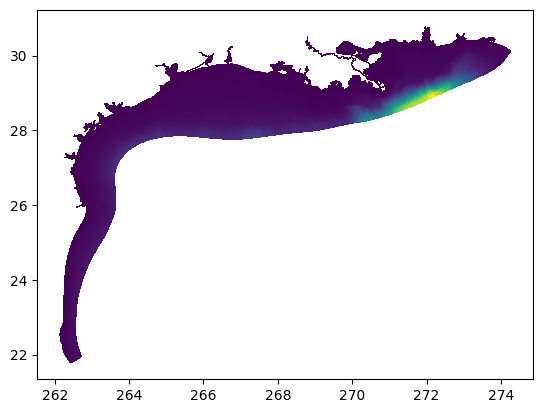

In [5]:
zeta = ds.zeta.cf.isel(time=0)
tris = tri.Triangulation(zeta.cf['longitude'], zeta.cf['latitude'], ds.nv.T - 1)
plt.tripcolor(tris, ds.h)